### set up 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
import pickle
import warnings
warnings.filterwarnings("ignore")

/Users/peggylee/anaconda3/envs/Peggy/lib/python3.12/site-packages/threadpoolctl.py:1186: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


### data loading

In [2]:
path = '/Users/peggylee/Desktop/python/Kaggle_comptete/02_Data/original_data'
sample = pd.read_csv(f"{path}/sample_submission.csv")
train = pd.read_csv(f"{path}/train.csv")
test = pd.read_csv(f"{path}/test.csv")

In [3]:
print("train shape: ",train.shape)
print("test shape: ", test.shape)
print("train unique participants: ", len(train['p_num'].unique()))
print("train unique participants: ", train['p_num'].unique())
print("test unique participants: ", len(test['p_num'].unique()))
print("test unique participants: ", test['p_num'].unique())

train shape:  (177024, 508)
test shape:  (3644, 507)
train unique participants:  9
train unique participants:  ['p01' 'p02' 'p03' 'p04' 'p05' 'p06' 'p10' 'p11' 'p12']
test unique participants:  15
test unique participants:  ['p01' 'p02' 'p04' 'p05' 'p06' 'p10' 'p11' 'p12' 'p15' 'p16' 'p18' 'p19'
 'p21' 'p22' 'p24']


In [4]:
class DataTransformer:
    def __init__(self,train_df, test_df):
        self.train = train_df
        self.test = test_df
        self.fixed_train = ['id','p_num','time','bg+1:00']
        self.fixed_test = ['id','p_num','time']
    
   
    def melt_column(self, colnames, df, newcolname,newcolvalue, fixed_col):
        df_melt = pd.melt(df,id_vars = fixed_col, value_vars = colnames, var_name = newcolname, value_name = newcolvalue)
        return df_melt
    
    def reshape_df(self, df, type_data):
        temp1 = df.copy()
        temp1.loc[:, 'time_temp'] = pd.to_datetime(temp1['time'], format="%H:%M:%S").dt.time
        temp1.loc[:, 'day'] = self.generate_day_column(temp1)
        
        max_time = temp1['day'].max()
        time_sequence_data = self.create_time_sequence(max_time)
        
        temp1.loc[:,'time_pre'] = pd.to_datetime(temp1['time'], format = "%H:%M:%S")
        temp1 = self.calculate_outcome_columns(temp1)

        if type_data == "test":
            temp2 = temp1[['day_outcome', 'time_pre_outcome', "id", "p_num"]]
            
        fixed_colname = temp1.drop(columns=temp1.columns[3:507]).columns
        melt_final = self.create_long_form(temp1, fixed_colname)
        melf_final = self.adjust_time_columns(melt_final)
        melt_final_original2 = self.arange_drop_dup(melt_final, time_sequence_data)

        if type_data == "train":
            train_final = self.combine_and_finalize_train(melt_final, time_sequence_data,melt_final_original2)
            return {'train': train_final}
        else:
            return {'test': melt_final_original2, 'output': temp2}
        
    def generate_day_column(self, temp1):
        day = [1]*len(temp1)
        k = 1
        for i in range(1,len(temp1)):
            if temp1['time_temp'].iloc[i] <= temp1['time_temp'].iloc[i-1]:
                k += 1
            day[i] = k
        return day
    
    def create_time_sequence(self, max_time):
        time_sequence = pd.date_range("00:00","23:55",freq = "5T").time
        time_sequence_data = pd.DataFrame({     
            'time_seq': np.tile([t.strftime("%H:%M:%S") for t in time_sequence], max_time),
            'day': np.repeat(np.arange(1, max_time + 1), len(time_sequence)),
            'bg_measure': np.nan
        })
        return time_sequence_data
    
    def calculate_outcome_columns(self, temp1):
        ## original time turn into "seconds" and plus one hour. Based on this calculation to define the "day"
        temp1.loc[:,'time_pre_seconds'] = (temp1['time_pre'].dt.hour * 3600 + temp1['time_pre'].dt.minute * 60 + temp1['time_pre'].dt.second + 3600)
        
        temp1.loc[:,'day_outcome'] = np.where(temp1['time_pre_seconds'] >= 86400, 
                                        temp1['day'] + 1, 
                                        temp1['day'])
        temp1.loc[:,'time_pre_outcome'] = pd.to_timedelta(temp1['time_pre_seconds'], unit='s').apply(lambda x: str(x).split()[2])
        return temp1
    
    def create_long_form(self, temp1, fixed_colname):
        bg_bf = temp1.columns[temp1.columns.str.startswith('bg-')]
        insulin_bf = temp1.columns[temp1.columns.str.startswith('insulin-')]
        carbs_bf = temp1.columns[temp1.columns.str.startswith('carbs-')]
        hr_bf = temp1.columns[temp1.columns.str.startswith('hr-')]
        step_bf = temp1.columns[temp1.columns.str.startswith('steps-')]
        cals_bf = temp1.columns[temp1.columns.str.startswith('cals-')]
        activity_bf = temp1.columns[temp1.columns.str.startswith('activity-')]
        
        bg_melt = self.melt_column(bg_bf, temp1, "bg_time", "bg_value", fixed_col=fixed_colname)
        insulin_melt = self.melt_column(insulin_bf, temp1, "insulin_time", "insulin_value", fixed_col=fixed_colname)
        carbs_melt = self.melt_column(carbs_bf, temp1, "carbs_time", "carbs_value", fixed_col=fixed_colname)
        hr_melt = self.melt_column(hr_bf, temp1, "hr_time", "hr_value", fixed_col=fixed_colname)
        step_melt = self.melt_column(step_bf, temp1, "step_time", "step_value", fixed_col=fixed_colname)
        cals_melt = self.melt_column(cals_bf, temp1, "cals_time", "cals_value", fixed_col=fixed_colname)
        activity_melt = self.melt_column(activity_bf, temp1, "activity_time", "activity_value", fixed_col=fixed_colname)

        melt_pre1 = pd.concat([bg_melt, insulin_melt.drop(columns=fixed_colname)], axis=1)
        melt_pre1 = pd.concat([melt_pre1, carbs_melt.drop(columns=fixed_colname)], axis=1)
        melt_pre1 = pd.concat([melt_pre1, hr_melt.drop(columns=fixed_colname)], axis=1)
        melt_pre1 = pd.concat([melt_pre1, step_melt.drop(columns=fixed_colname)], axis=1)
        melt_pre1 = pd.concat([melt_pre1, cals_melt.drop(columns=fixed_colname)], axis=1)
        melt_pre1 = pd.concat([melt_pre1, activity_melt.drop(columns=fixed_colname)], axis=1)
        return melt_pre1
    
    def combine_and_finalize_train(self,melt_final, time_sequence_data,melt_final_original2):
        melt_final_outcome = melt_final[['day_outcome','time_pre_outcome','bg+1:00','insulin_value','carbs_value','hr_value','step_value','cals_value','activity_value']]
        melt_final_outcome = melt_final_outcome.sort_values(by = ['day_outcome','time_pre_outcome']).drop_duplicates(subset = ['day_outcome','time_pre_outcome'],keep = 'first').reset_index(drop = True)
        melt_final_outcome1 = melt_final_outcome.rename(columns = {
            'bg+1:00' : 'bg_value',
            'time_pre_outcome': 'time_seq', 
            'day_outcome': 'day'
        })
        col_order = melt_final_original2.columns
        melt_final_original2 = melt_final_original2.reset_index(drop=True)
        melt_final_outcome1 = melt_final_outcome1.reset_index(drop=True)
        
        melt_final_outcome1 = melt_final_outcome1[col_order]
        train_final = pd.concat([melt_final_original2, melt_final_outcome1], axis=0)
        train_final = train_final.sort_values(by=['day', 'time_seq']).drop_duplicates(subset=['day', 'time_seq'], keep='first').reset_index(drop=True)        
        return train_final
    
    def arange_drop_dup(self, melt_final, time_sequence_data):
        
        melt_final_original = melt_final[['day_final','final_time1','bg_value','insulin_value','carbs_value','hr_value','step_value','cals_value','activity_value']]
        ### arrange and drop duplicates two dataset ###
        melt_final_original =  melt_final_original.sort_values(by=['day_final','final_time1']).drop_duplicates(subset=['day_final','final_time1'], keep='first').reset_index(drop=True)
        melt_final_original2 = pd.merge(melt_final_original,time_sequence_data , left_on= ['day_final', 'final_time1'], right_on = ['day','time_seq'], how='outer')
        melt_final_original2 = melt_final_original2.drop(columns = ['day_final','final_time1','bg_measure']) 
        melt_final_original2 = melt_final_original2.sort_values(by = ['day','time_seq']).drop_duplicates(subset=['day','time_seq'], keep='first').reset_index(drop=True)
        melt_final_original2 = melt_final_original2.dropna(subset=['day','time_seq'], how='all')
    
        return melt_final_original2
    
    def adjust_time_columns(self, melt_final):
        melt_final['bg_time'] = melt_final['bg_time'].str.extract(r'(.*)-(.*)')[1]
        melt_final['bg_time1'] = pd.to_datetime(melt_final['bg_time'].str.pad(5, fillchar='0') + ":00", format="%H:%M:%S")
        melt_final['bg_time2'] = (melt_final['time_pre'] - melt_final['bg_time1']).dt.total_seconds()
        melt_final['final_time'] = pd.to_timedelta(melt_final['bg_time2'], unit='s')
        melt_final['day_final'] = np.where(melt_final['bg_time2'] < 0, melt_final['day'] - 1, melt_final['day'])
        melt_final['final_time1'] = melt_final['final_time'].apply(lambda x: str(x).split()[-1].replace('+', '').replace('-', ''))
        return melt_final

        

In [5]:
transformer = DataTransformer(train, test)

In [6]:
train_dict = {f'p{str(i).zfill(2)}_train': train[train['p_num'] == f'p{str(i).zfill(2)}'] for i in [1, 2, 3, 4, 5, 6, 10, 11, 12]}
reshaped_train_dict = {}
for key, df in train_dict.items():
    reshaped_train_dict[key] = transformer.reshape_df(df, "train")
with open('/Users/peggylee/Desktop/python/Kaggle_comptete/02_Data/Temp/reshaped_train_dict.pkl', 'wb') as f:
    pickle.dump(reshaped_train_dict, f)

In [7]:
test_dict = {f'p{str(i).zfill(2)}_test': test[test['p_num'] == f'p{str(i).zfill(2)}'] for i in [1, 2, 4, 5, 6, 10, 11, 12, 15, 16, 18 ,19, 21, 22, 24]}
reshaped_test_dict = {}
for key, df in test_dict.items():
    reshaped_test_dict[key] = transformer.reshape_df(df, "test")
    
with open('/Users/peggylee/Desktop/python/Kaggle_comptete/02_Data/Temp/reshaped_test_dict.pkl', 'wb') as f:
    pickle.dump(reshaped_test_dict, f)  

In [8]:
def table1(df,dropcols):
    df = df.drop(columns = dropcols)
    stats = df.describe()
    Q1 = stats.loc['25%']
    Median = stats.loc['50%']
    Q3 = stats.loc['75%']
    missing_rate = ((df.shape[0]-stats.loc['count'])/df.shape[0])*100
    
    valid_columns = stats.columns
    ## table1 ##
    formatted_summary = pd.DataFrame({
        "Median (Q1, Q3)": [f"{median:.2f} ({q1:.2f}, {q3:.2f})"
                                 for median, q1, q3 in zip(Median, Q1, Q3)],
       "Missing rate (%)": [f"{missing:.2f}" for missing in missing_rate]
    },index=valid_columns)
    return formatted_summary

In [9]:
for key, sub_dict in reshaped_train_dict.items():
    print(key)
    if  'train' in  sub_dict:
        temp = sub_dict['train']
        dropcol = ['time_seq','day']
        table1_df = table1(temp,dropcol)
        print(table1_df)
        print("\n")
        print("======================================================")

p01_train
                    Median (Q1, Q3) Missing rate (%)
bg_value         8.10 (5.60, 11.60)            67.62
insulin_value     0.03 (0.03, 0.06)             0.21
carbs_value    23.00 (15.50, 33.50)            98.39
hr_value       75.90 (62.60, 88.10)             5.83
step_value      18.00 (0.00, 87.00)            30.97
cals_value       5.50 (4.80, 10.98)             1.34


p02_train
                     Median (Q1, Q3) Missing rate (%)
bg_value          8.80 (7.20, 11.00)             2.08
insulin_value      0.08 (0.05, 0.10)             0.61
carbs_value     50.00 (31.00, 60.00)            98.74
hr_value        80.00 (70.00, 93.05)            78.70
step_value     75.00 (31.00, 154.00)            84.14
cals_value         2.99 (1.66, 5.39)            71.45


p03_train
                    Median (Q1, Q3) Missing rate (%)
bg_value         7.90 (6.30, 10.40)             1.49
insulin_value     0.13 (0.08, 0.19)             0.26
carbs_value    79.50 (60.00, 90.00)            98.81
hr_va

In [10]:
def plot_bg(df,person,day):
    # 設定圖形大小
    plt.figure(figsize=(12, 6))

    # 繪製折線圖
    plt.plot(df['time_seq'], df['bg_value'], color='blue', marker='o', linestyle='-', linewidth=1, markersize=4)

    # 添加標題和軸標籤
    plt.title(f"Blood Glucose Levels Over Time for Person {person} (Day {day})")
    plt.xlabel("Timestamp")
    plt.ylabel("Blood Glucose (mg/dL)")

    # 儲存或顯示圖形
    plt.grid(True)
    plt.xticks(rotation=45)  # 旋轉 x 軸上的時間標籤以避免重疊
    plt.tight_layout()       # 自動調整圖形以避免標籤被截斷
    plt.show()

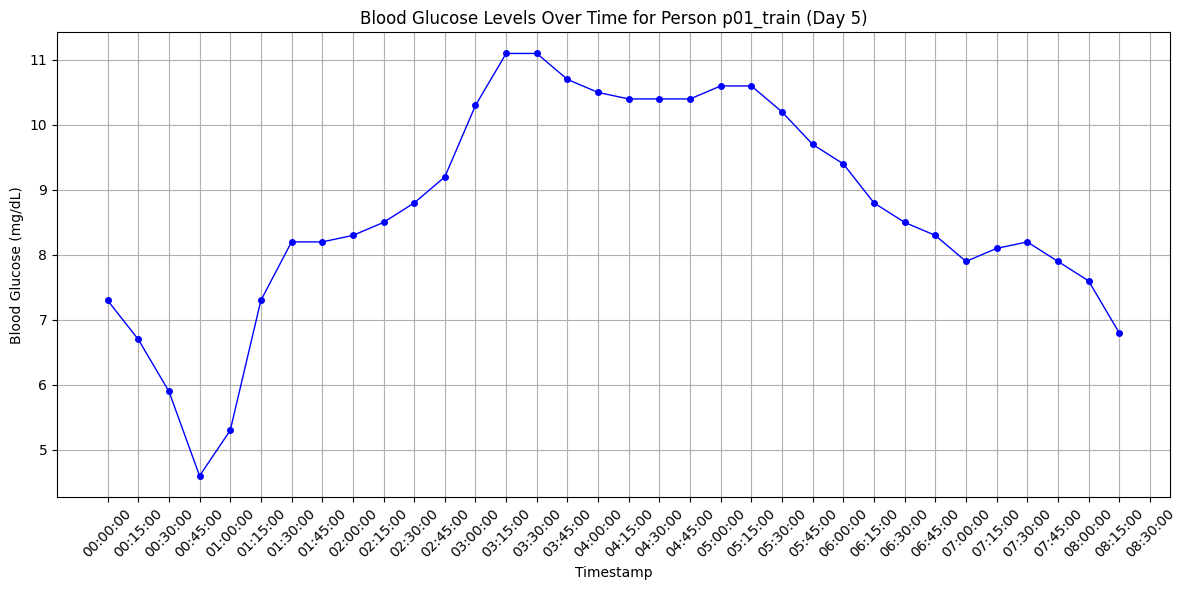

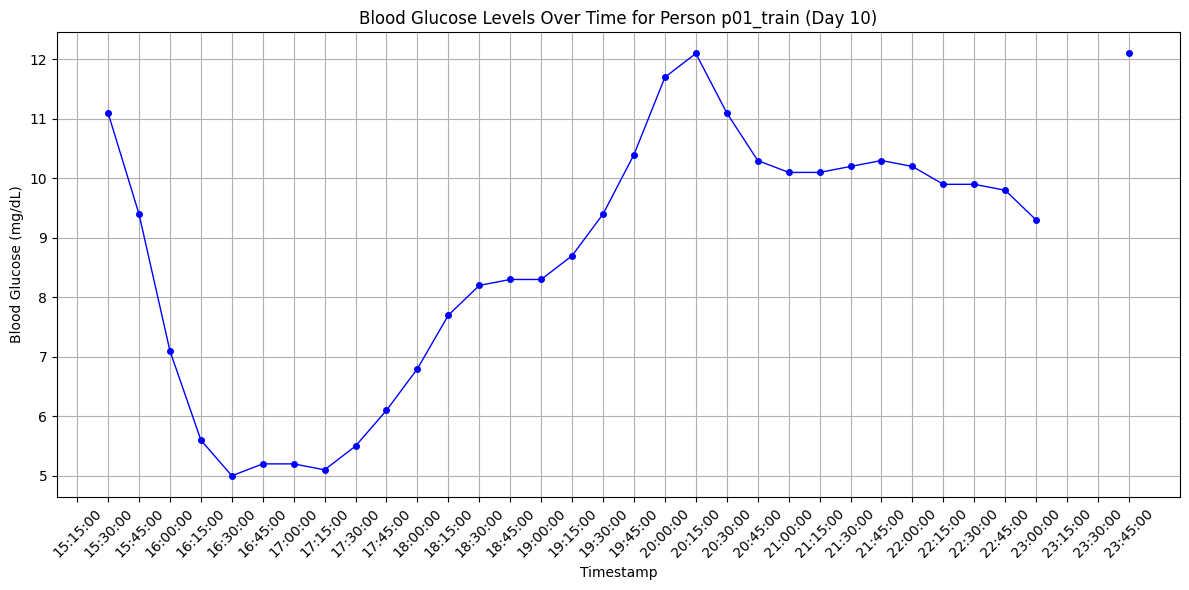

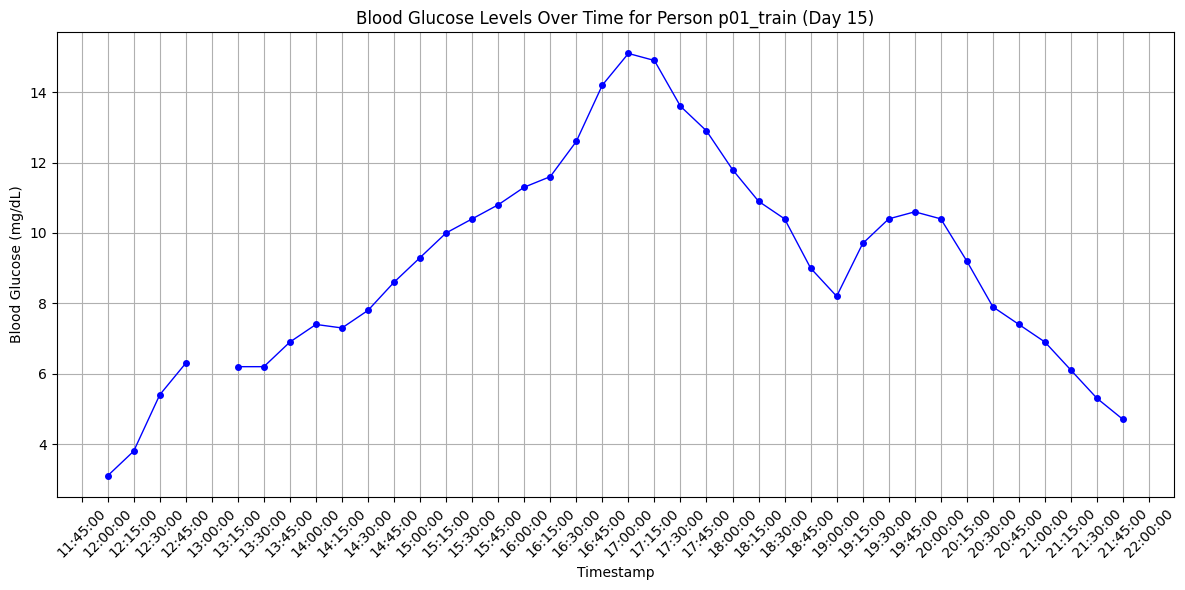

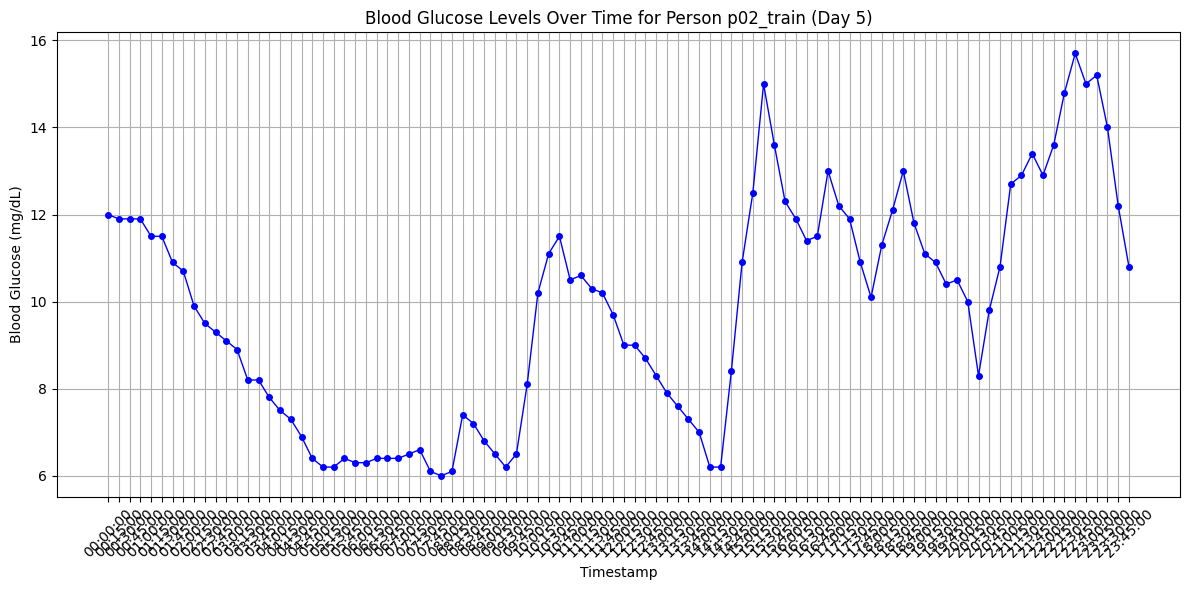

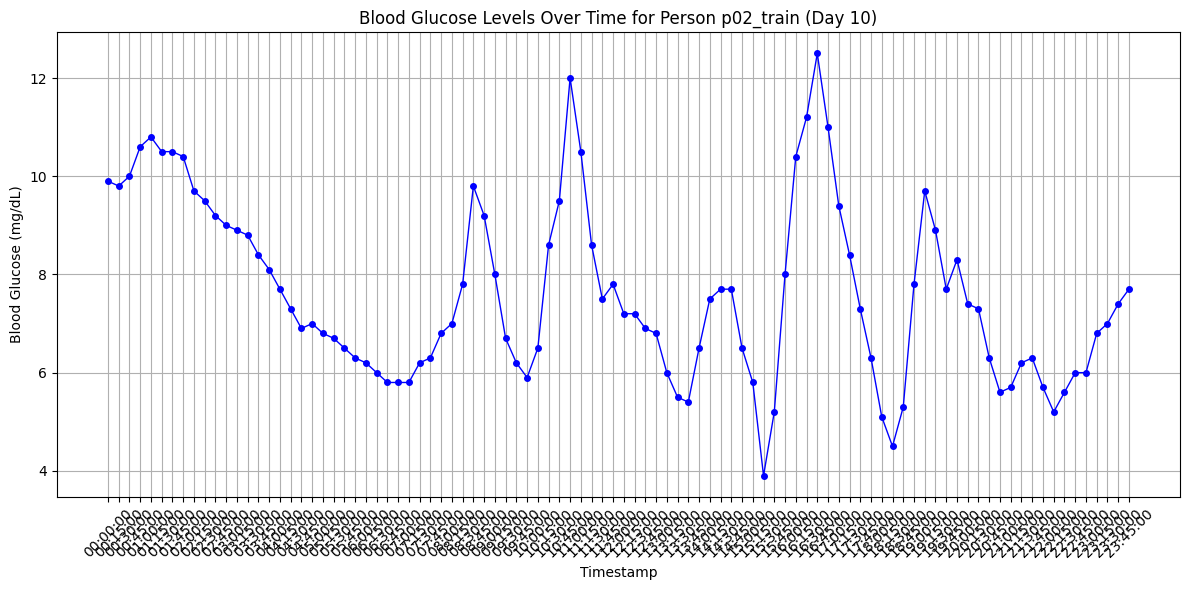

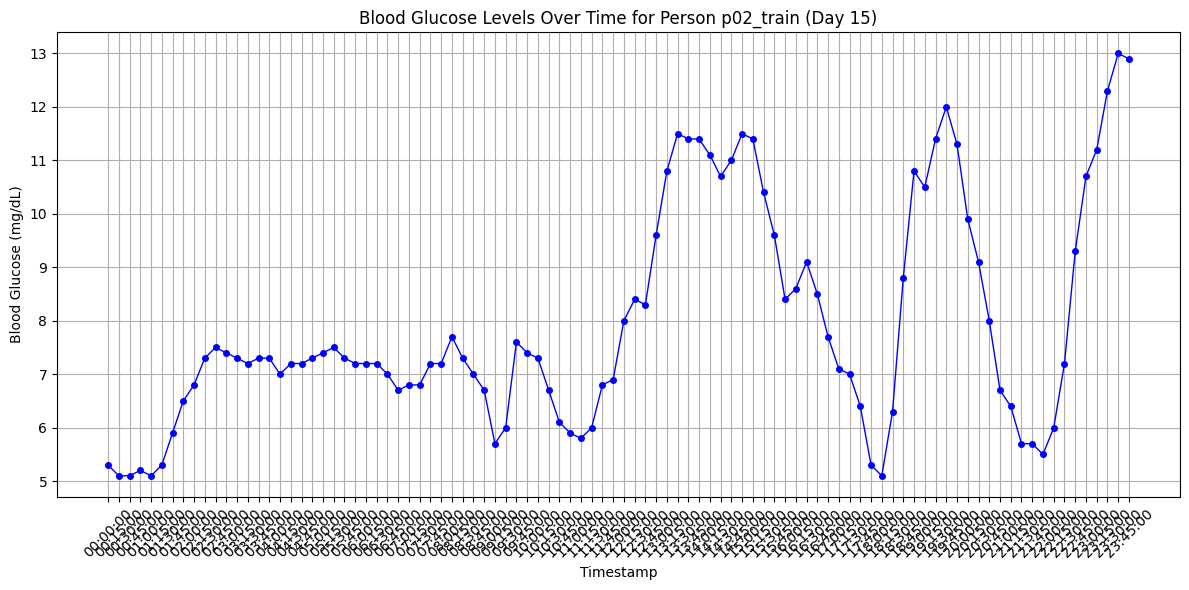

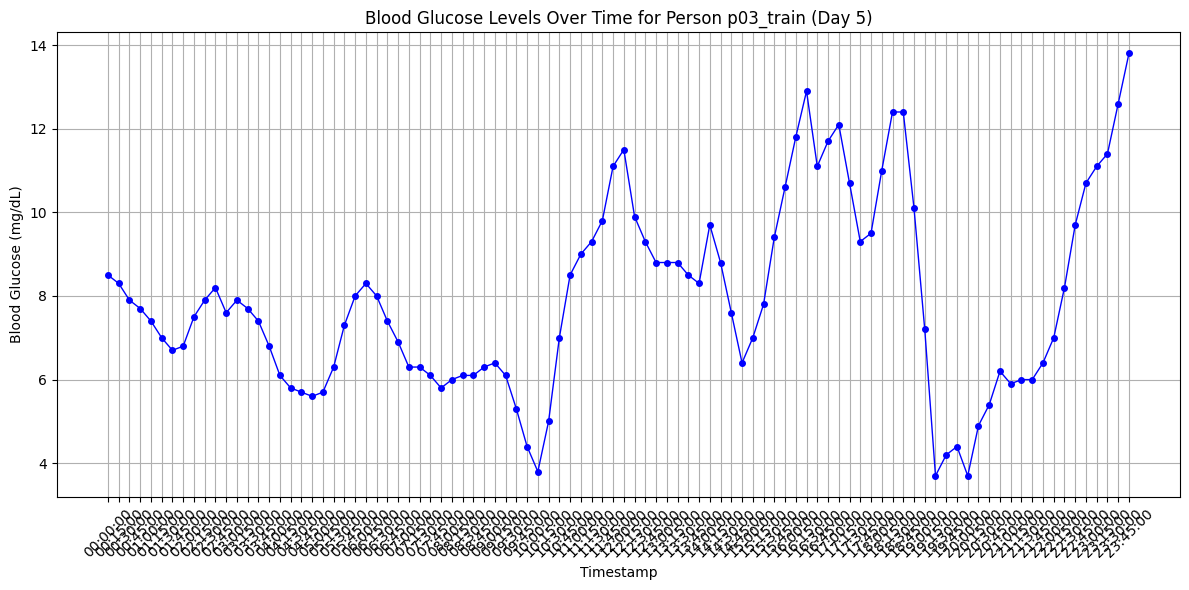

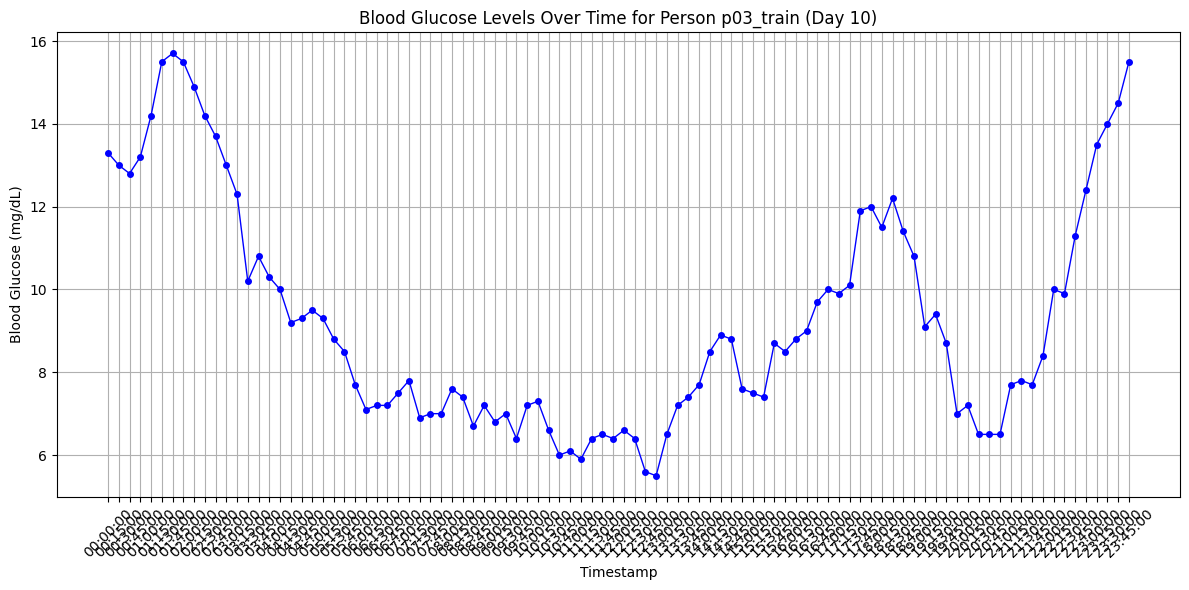

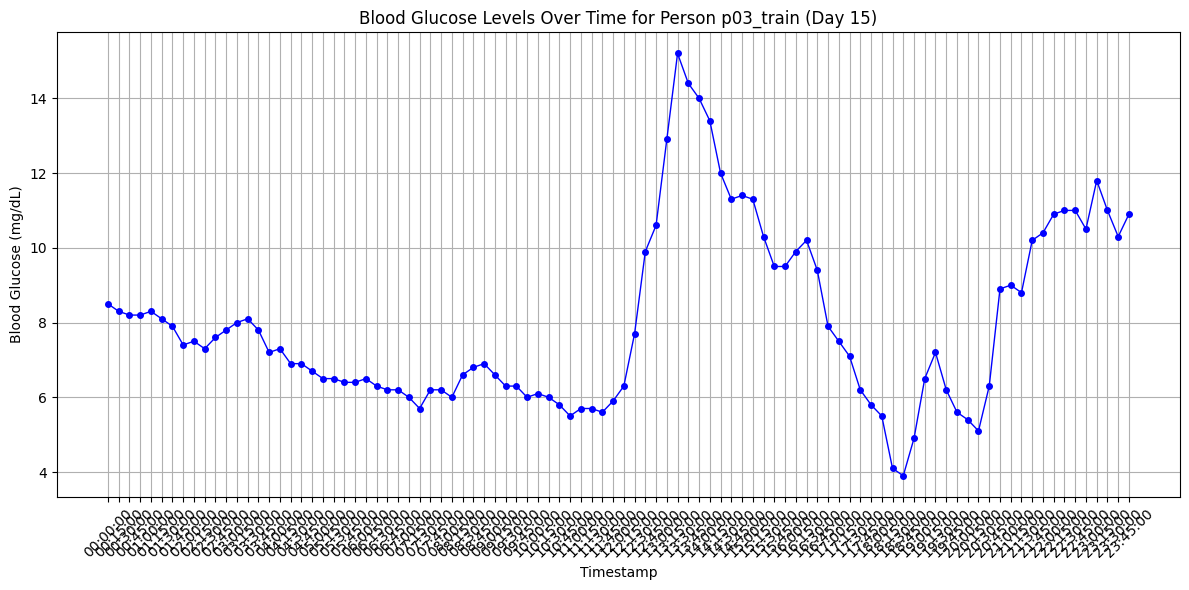

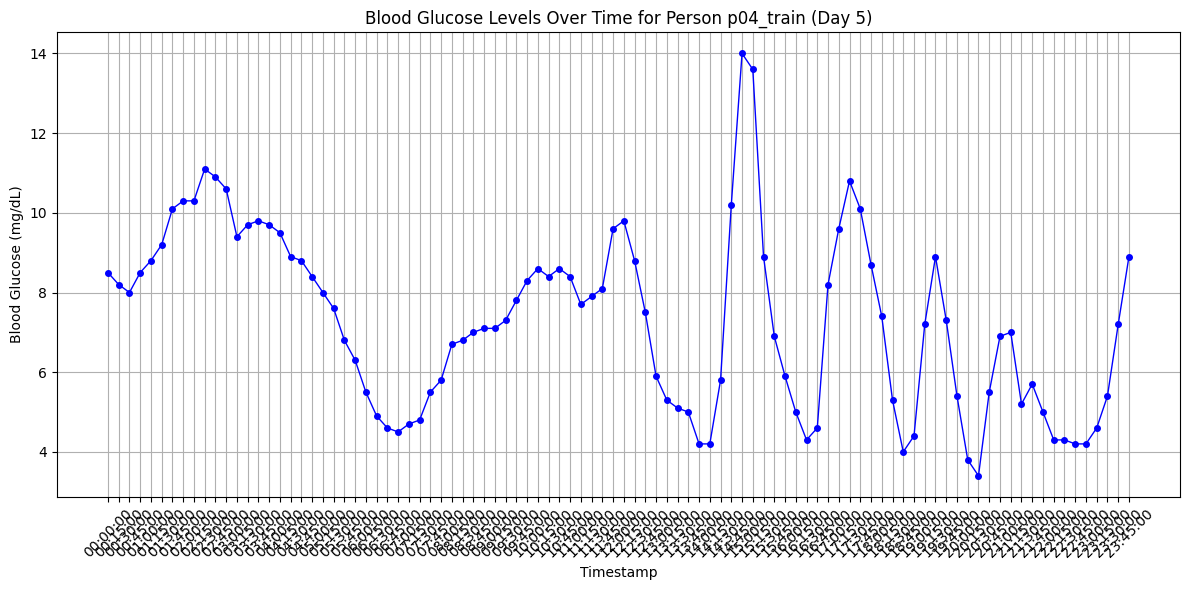

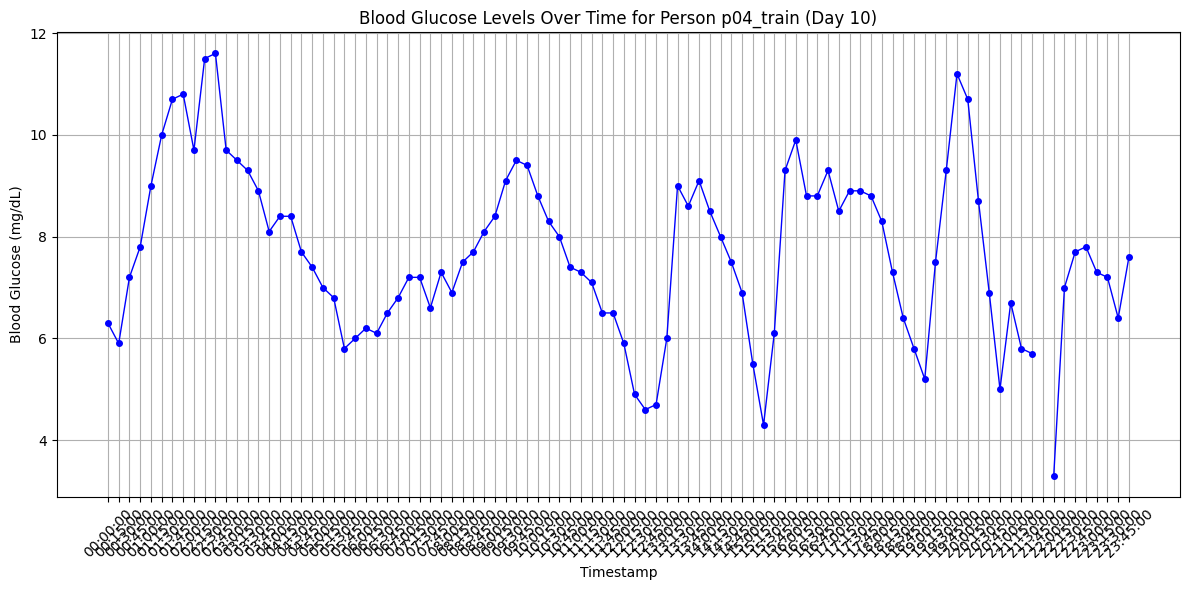

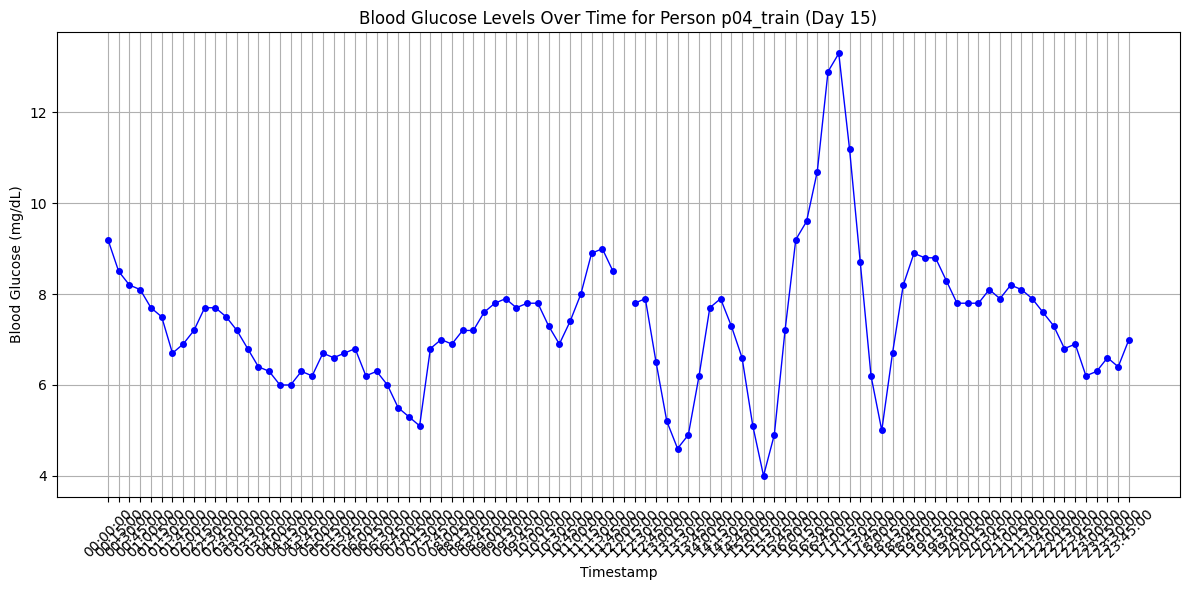

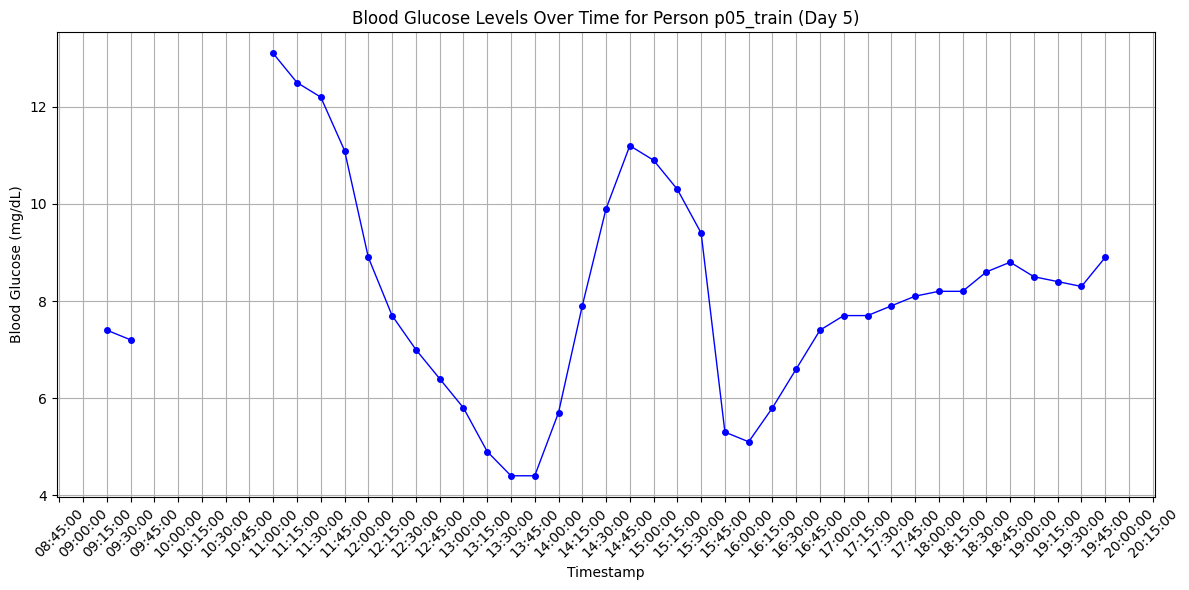

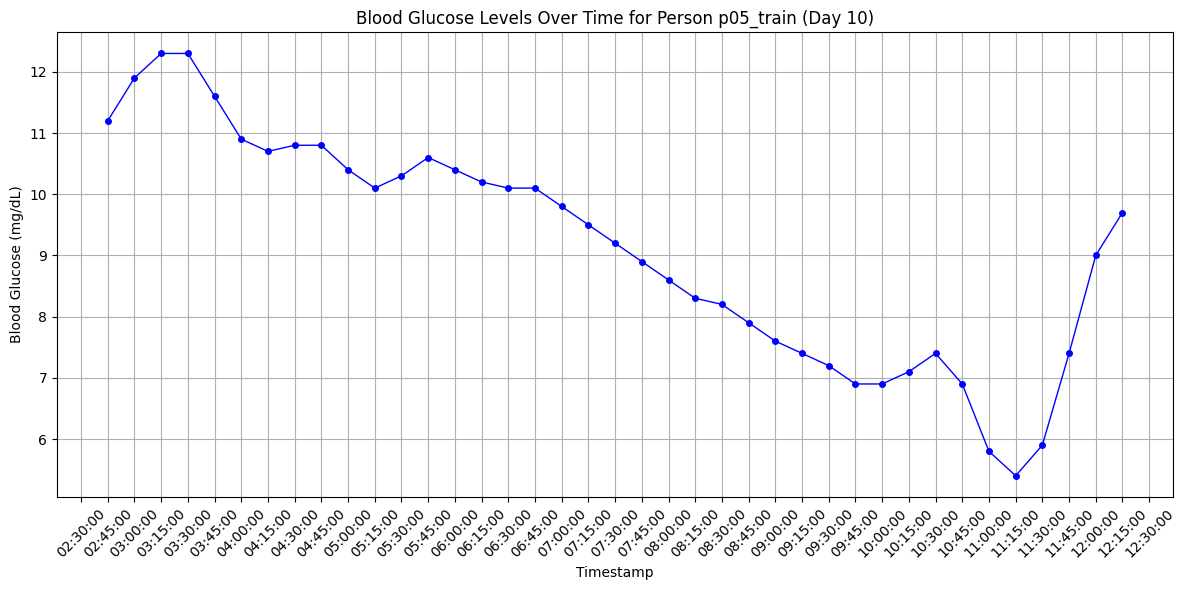

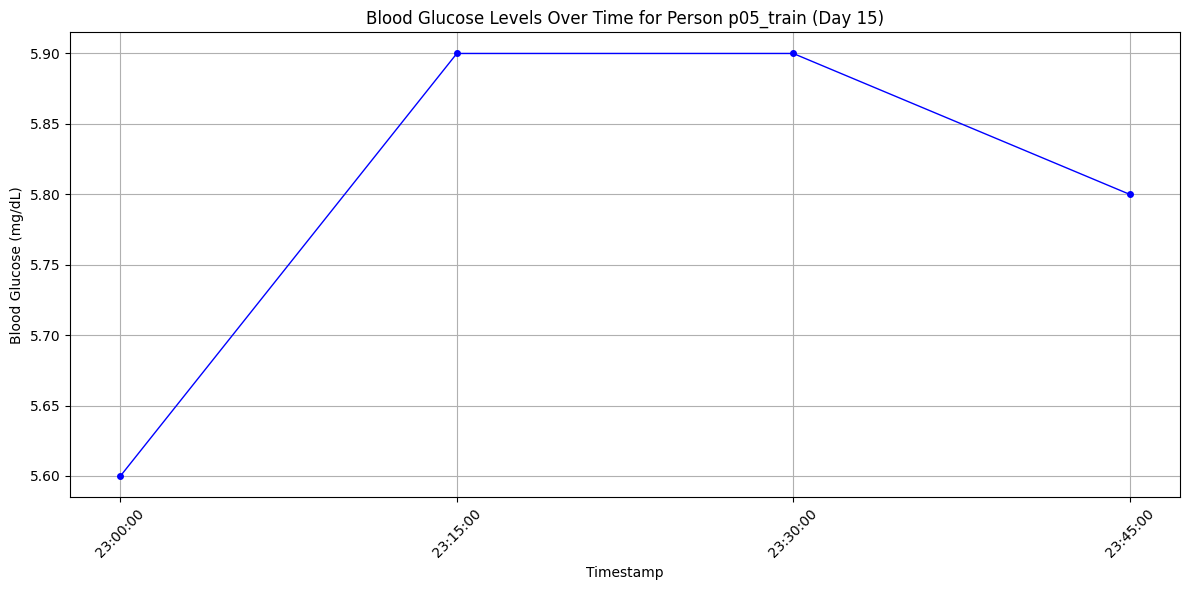

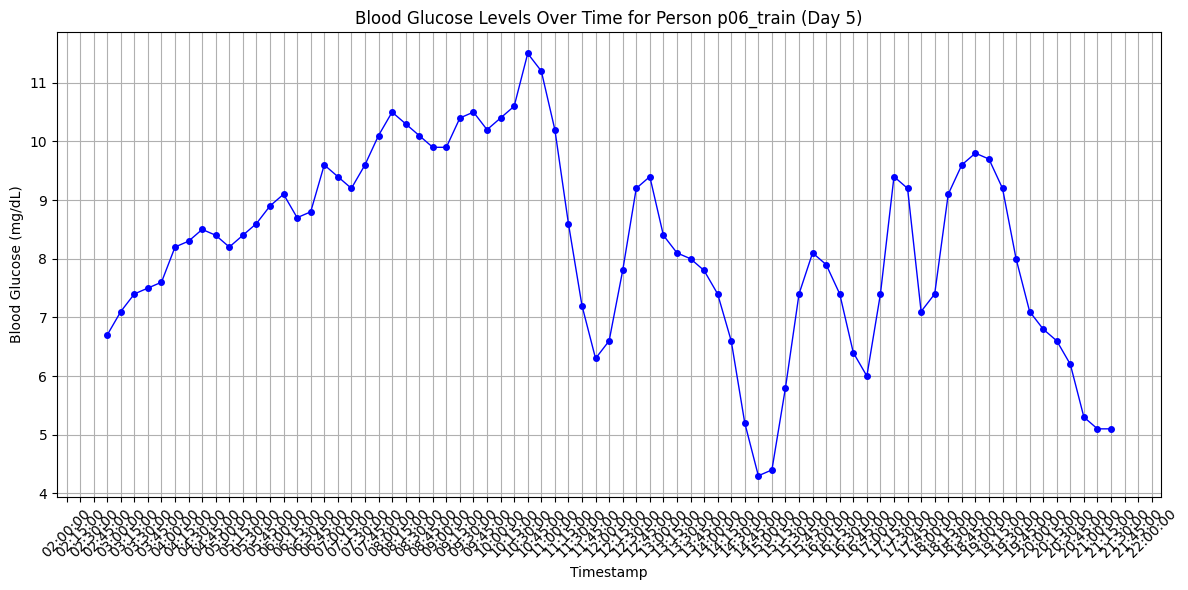

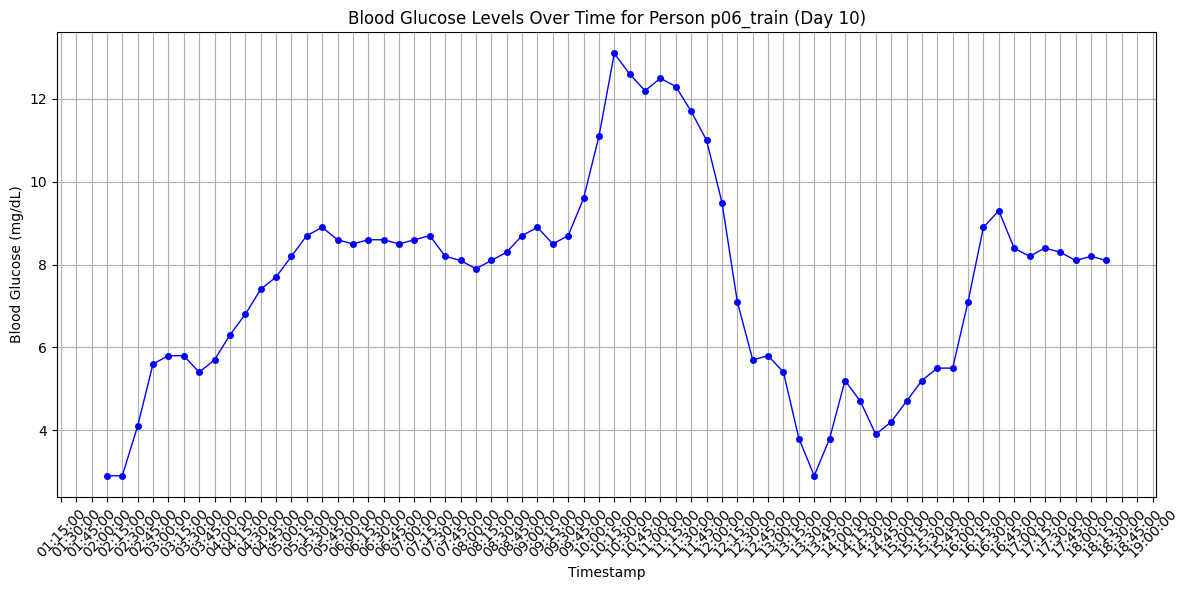

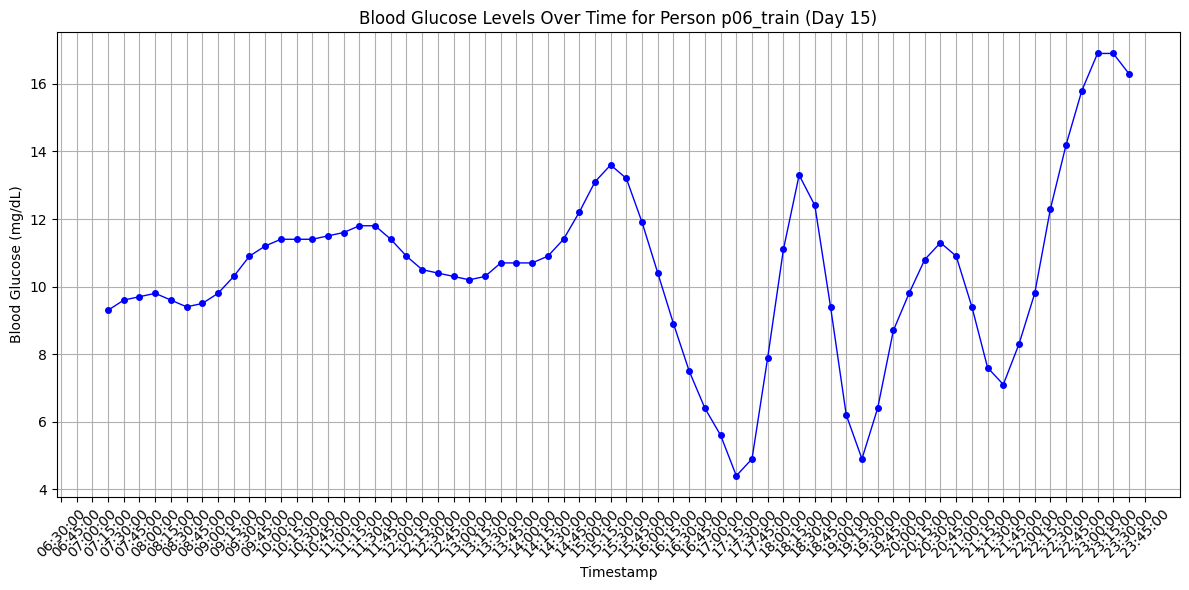

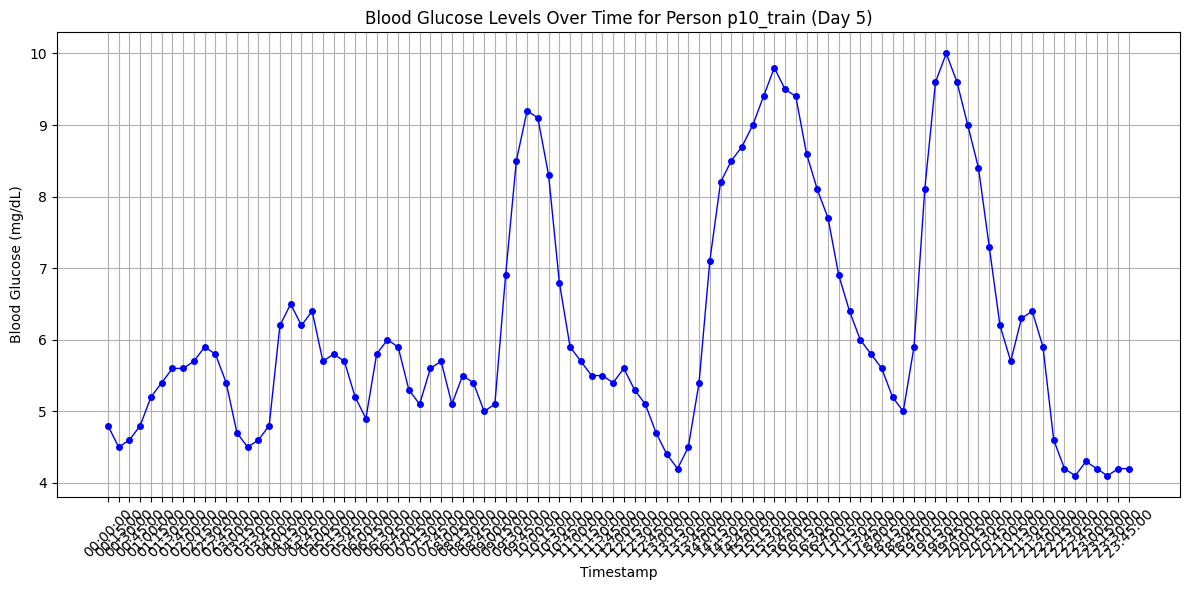

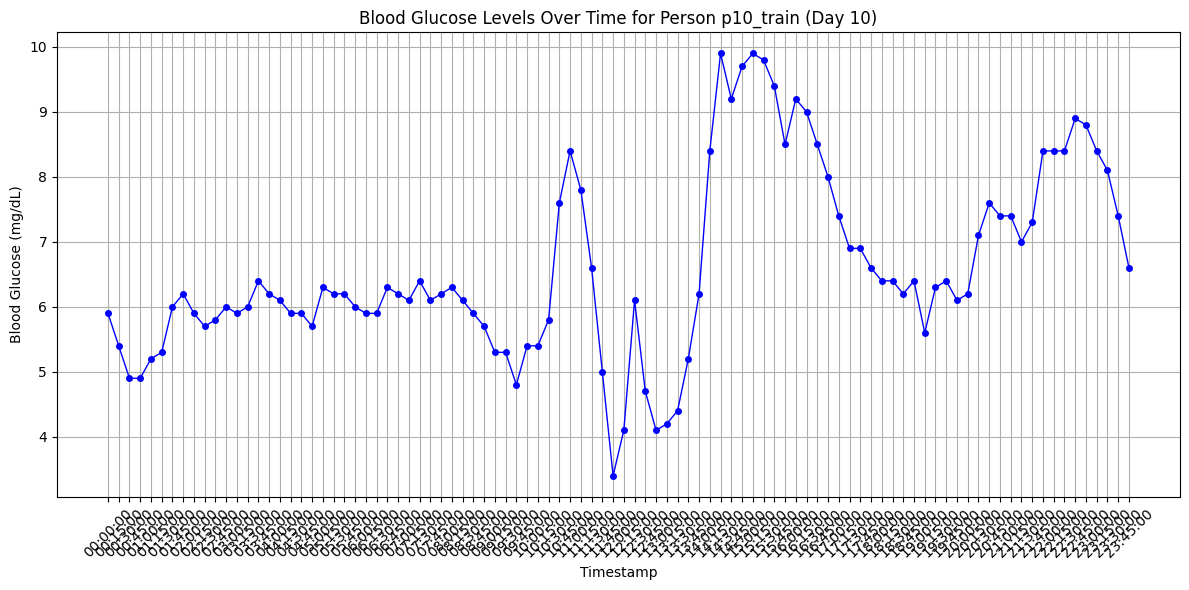

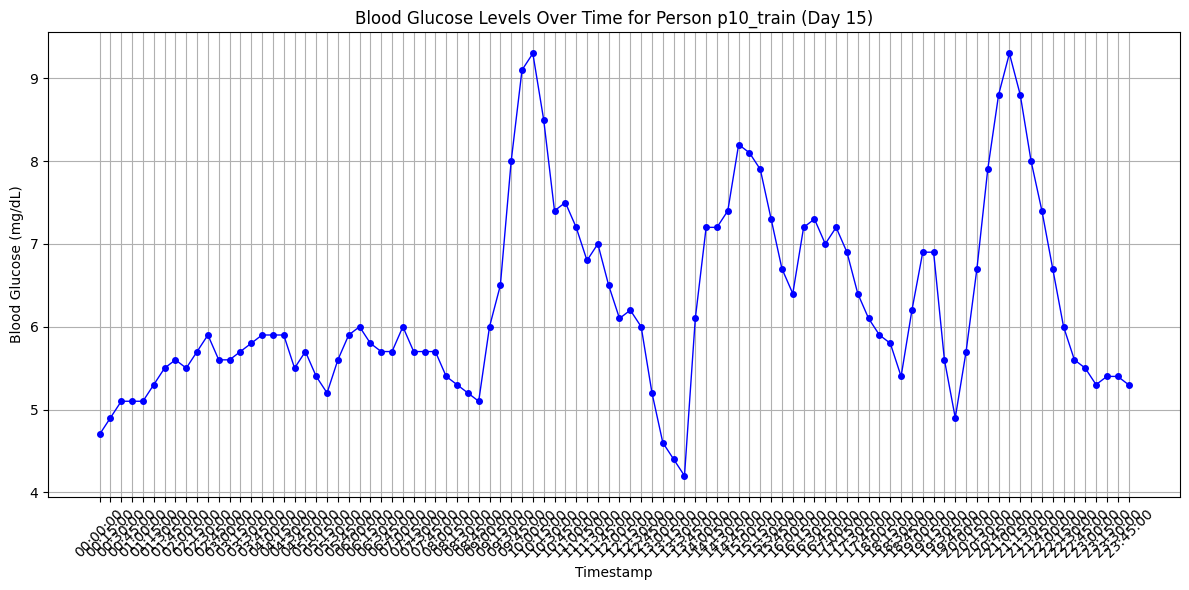

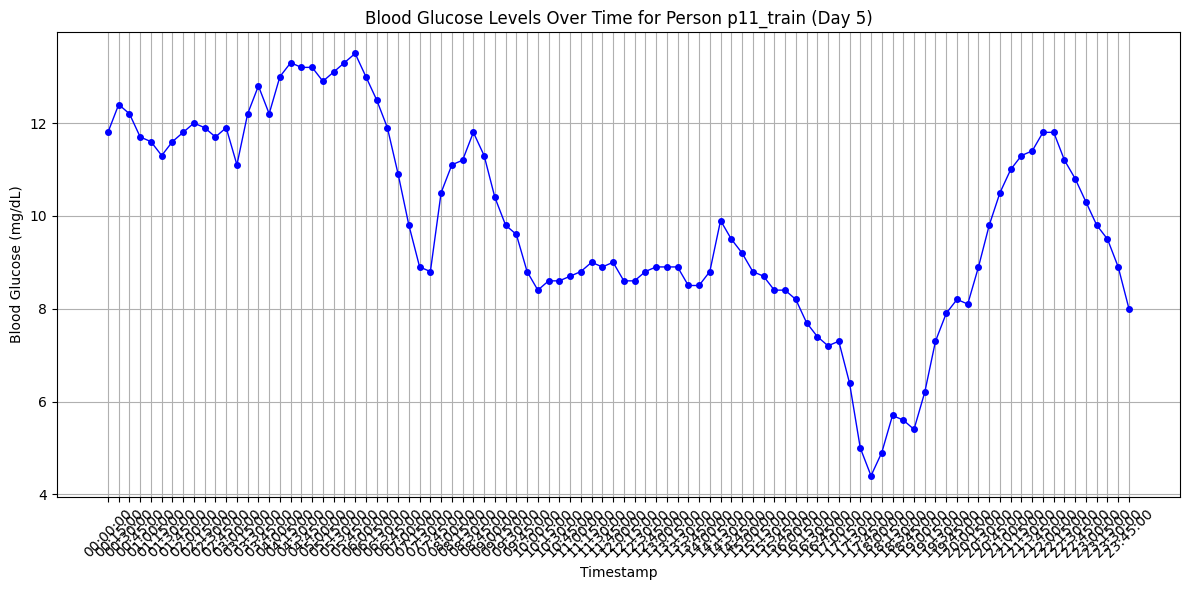

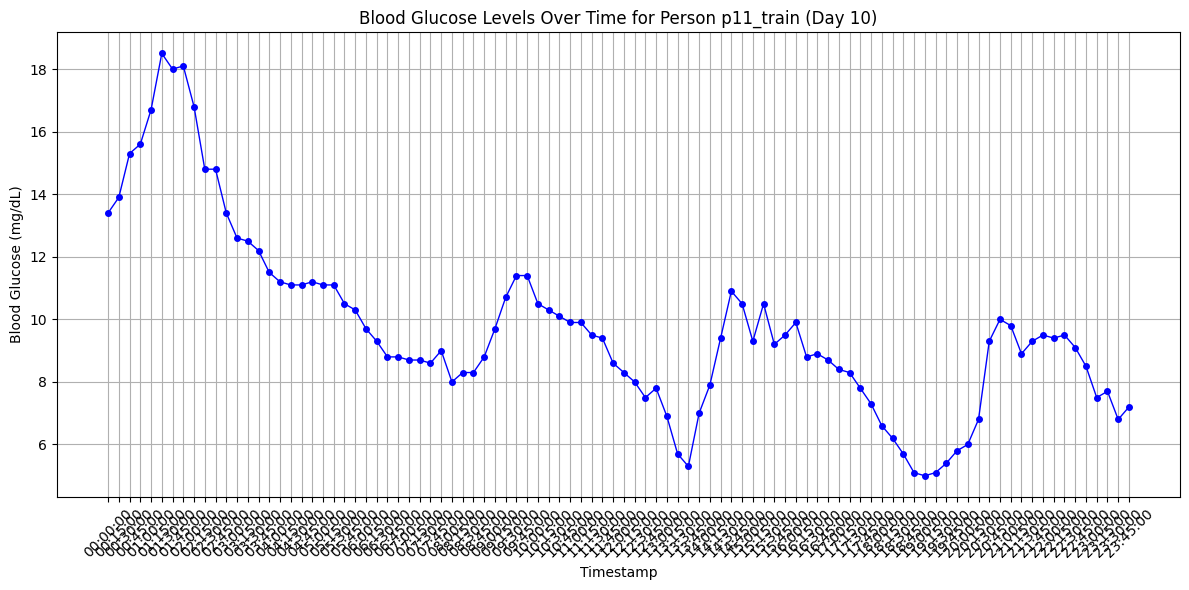

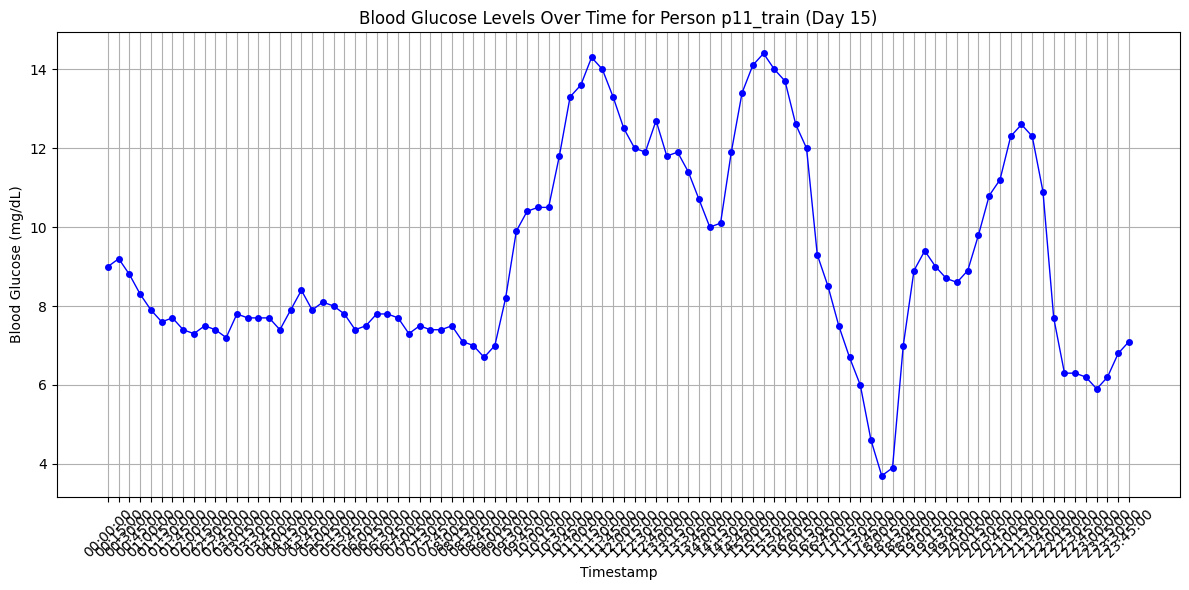

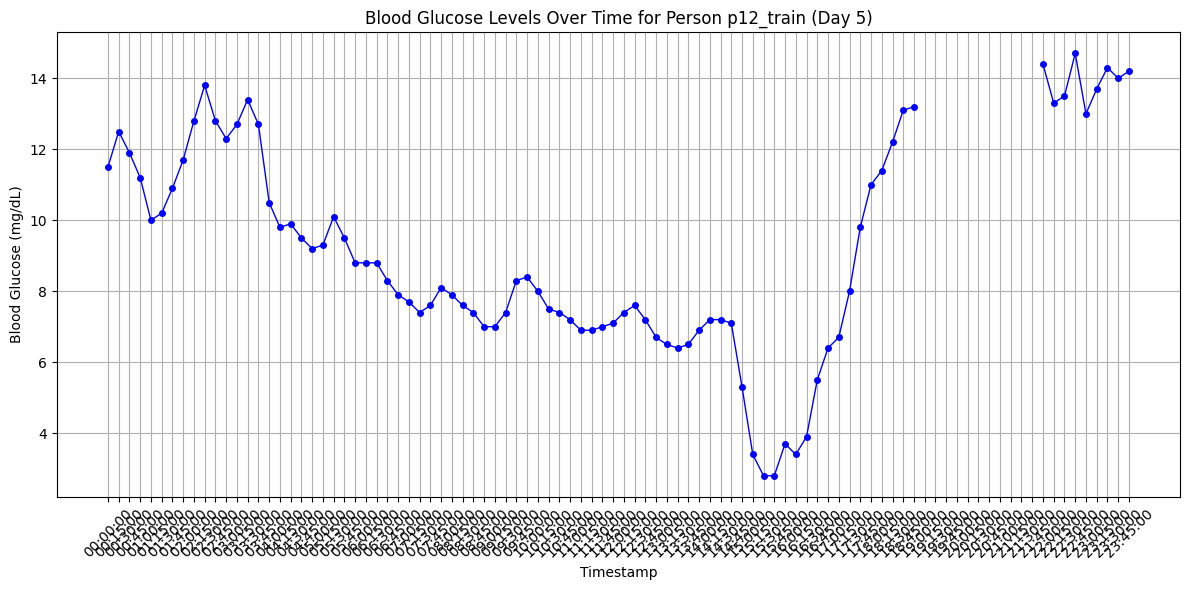

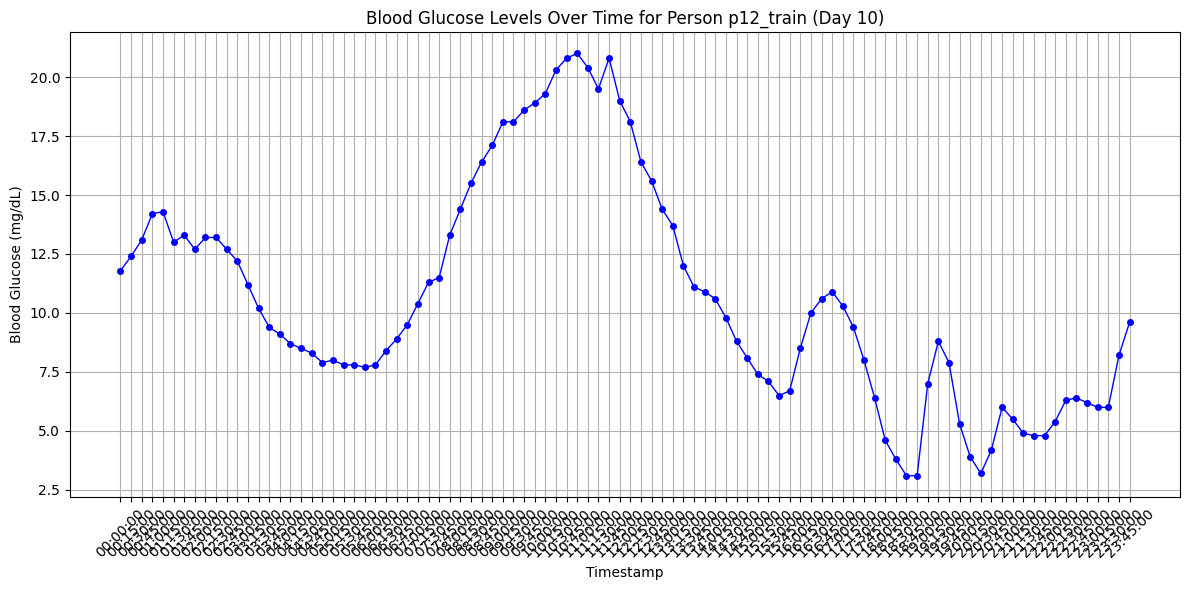

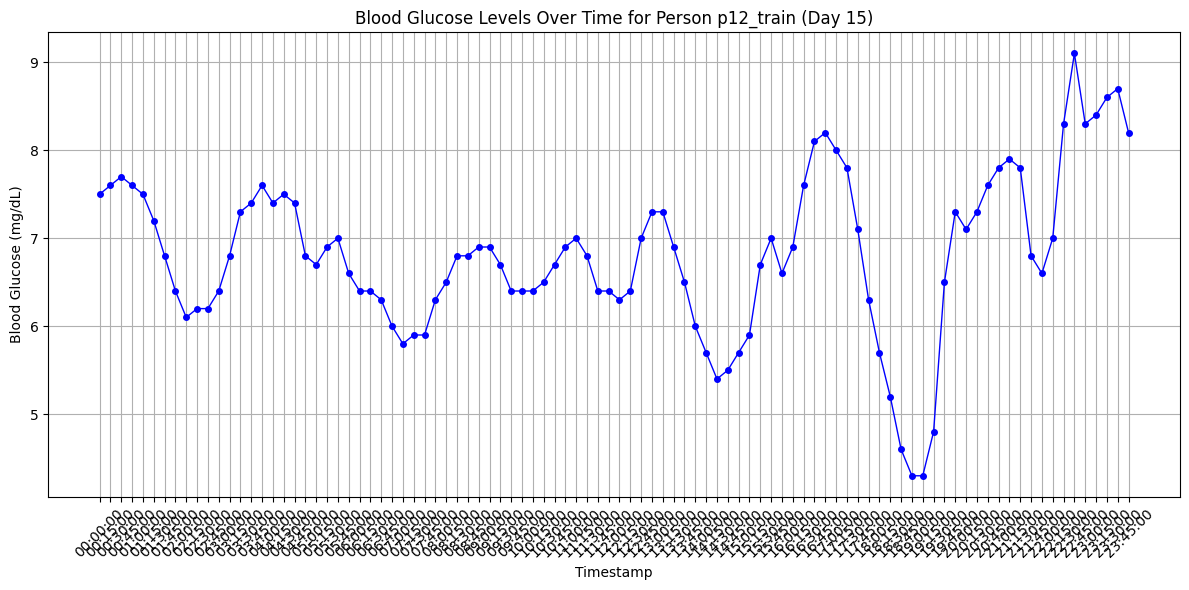

In [11]:
for key, sub_dict in reshaped_train_dict.items():
    temp = sub_dict['train']
    for i in [5,10,15]:
        temp1 = temp[temp['day']==i]
        temp1 = temp1.iloc[::3].reset_index(drop=True)
        plot_bg(temp1,key,i)